# <span style="color:blue">Esercitazione 11</span>

L'obiettivo della lezione è di sperimentare l'utilizzo delle reti neurali (*neural network*, NN). In particolare vengono affrontati con delle reti di tipo *feedforward* (modello <font face="Courier">Sequential</font> della libreria <font face="Courier">Keras</font>) tre problemi di regressione lineare.

Attraverso una serie di tentativi e di sperimentazioni voglio arrivare a costruire delle NN che siano in grado, grazie ad una fase di training correttamente impostata, di adattare i propri parametri liberi in modo che la sequenza di layer e neuroni che le costituiscono riproducano il più accuratamente possibile, nelle loro operazioni collettive di mappatura dell'input, la funzione target del problema. In linea di principio questo obbiettivo è sempre raggiungibile (teorema di approssimazione universale).

In altre parole una NN può essere in generale vista come una trasformazione non lineare che mappa ogni input nel relativo output in un modo che è funzione dei parametri della rete, ovvero del'insieme dei parametri delle funzioni risposta $\psi_i^j$ dei singoli neuroni ($i$ e $j$ sono gli indici rispettivamente di neurone e di layer), ottenute tipicamente componendo una risposta lineare con una funzione di attivazione $\phi_i^j$,

$$ \psi_i^j (\vec{x}_{j-1}) = \phi_i^j \ (\ \vec{x}_{j-1} \cdot \vec{w}_{i,j} + \ b_{i,j}) = x_{i,j}$$

dove ${x}_{j-1}$ è il vettore di output del layer precedente e $\vec{w}_{i,j}$ e $b_{i,j}$ sono rispettivamente i pesi e i bias del neurone considerato.\
Mentre la forma delle funzioni di attivazione rientra nella creazione e nella struttura della NN, la selezione dei parametri che completano le definizioni delle funzioni risposta viene operata nella fase di training, in cui la macchina apprende quali sono i valori da assegnare ad essi per rappresentare la funzione target il meglio possibile. A questo punto l'approssimazione cercata viene ottenuta andando in ogni layer a utilizzare gli output $x_{i,j}$ dei singoli neuroni come input $\vec{x}_j$ per i layer successivi. Le trasformazioni semplici implementate dai singoli neuroni vengono composte e sovrapposte più volte, e questo permette in generale di approssimare, a un adeguato livello di complessità della rete, qualunque funzione continua con un grado arbitrario di precisione.

### Esercizio 11.1

Parto da dati distribuiti secondo la relazione lineare $ f(x)=2x+1 $.

La macchina sarà allenata nell'intervallo $[-1,1]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from mpl_toolkits.mplot3d import Axes3D

I dati di training e di validazione sono generati casualmente nell'intervallo $[-1,1]$ di interesse. Nella prima prova $N_{train}=100$ e $N_{valid}=10$ e i dati sono privi di rumore.

Il primo gruppo di dati è utilizzato per cercare di ottimizzare i valori dei parametri minimizzando il *training error* $E_{in}$, il secondo per valutare la validità delle previsioni finali della macchina su dei dati mai visti prima. Nei problemi che seguono il controllo è più immediato nel confronto con la funzione target, ma nei problemi reali questa è sconosciuta e i dati di validazione forniscono l'unico punto di riferimento esistente, reso quantitativo dal calcolo dell'*out-of-sample error* $E_{out}$.\
In questo primo esercizio l'unica funzione costo utilizzata per il calcolo degli errori è la *mean square-error*,
$$ MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2 $$
dove $y_j^\mathrm{pred}$ sono le predizioni della rete, $y_j$ gli output veri.

In [2]:
np.random.seed(0)

def data_gen(ntrain,nvalid,target_f,sigma):  #sigma is noise standard deviation for y train and valid
    #generate training data
    x_train = np.random.uniform(-1, 1, ntrain)
    y_train = np.random.normal(target_f(x_train),sigma)  #actual measures from which we want to guess regression parameters
    #generate validation data
    x_valid = np.random.uniform(-1, 1, nvalid)
    y_valid = np.random.normal(target_f(x_valid),sigma)
    # ideal (target) function
    x_target = x_valid      #the same of x_valid for error evaluation and comparison
    y_target = target_f(x_target)
    return ((x_train,y_train),(x_valid,y_valid),(x_target,y_target))

m = 2; b = 1  #target parameters of f(x) = m*x + b
def linear(x): return m*x + b
aa,bb,cc,dd=4.,-3.,-2.,3. #target parameters of f(x) = a + b*x + c*x**2 + d*x**3
def polynomial(x): return aa + bb*x + cc*x**2 + dd*x**3

def reg_plot(x,y,x_target,y_target,ylab): #plot training and target dataset
    plt.plot(x_target,y_target, label='target')
    plt.scatter(x,y, color='r',s=10, label=ylab+' data')
    plt.legend(loc="best")
    plt.grid(True); plt.show()

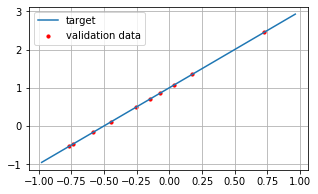

In [3]:
lin_data=data_gen(100,10,linear,0)
xtg=np.random.uniform(-1, 1, 80)  #x_target only for the graph
xtg.sort()
ytg=linear(xtg)

plt.figure(figsize=(5,3))
reg_plot(lin_data[1][0],lin_data[1][1],xtg,ytg,'validation')

In questo caso molto semplice è sufficiente una rete composta dai soli layer di input e di output, entrambi a singolo neurone. Infatti se come funzione di attivazione viene scelta l'identità (opzione di default), allora, come spiegato all'inizio, l'output dell'unico neurone mappante presente, e quindi della rete, sarà proprio del tipo $g(x)=p_1 x + p_2$, con $p_1$ e $p_2$ unici parametri da ottimizzare nella fase di training. Con un training efficace questa rete, per quanto essenziale, è del tutto in grado di riprodurre completamente la funzione target.

In [4]:
def composeNN_singleN(data,bsize,epochs,iffirst):
    #compose the NN model
    model = tf.keras.Sequential()
    model.add(Dense(1, input_shape=(1,)))
    #compile the model choosing optimizer, loss and metrics objects
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    #get a summary of our composed model
    if(iffirst): model.summary(); print(); print()
    
    # fit the model using training dataset
    # report training progress against validation data
    history = model.fit(x=data[0][0],y=data[0][1], 
          batch_size=bsize, epochs=epochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(data[1][0],data[1][1]))
    return model,history

In [5]:
lin1,lin1_hist = composeNN_singleN(lin_data,32,30,True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
4/4 [==============================] - 1s 166ms/step - loss: 3.3490 - mse: 3.3490 - val_loss: 1.6030 - val_mse: 1.6030
Epoch 2/30
4/4 [==============================] - 0s 28ms/step - loss: 3.1521 - mse: 3.1521 - val_loss: 1.5032 - val_mse: 1.5032
Epoch 3/30
4/4 [==============================] - 0s 28ms/step - loss: 2.9487 - mse: 2.9487 - val_loss: 1.3961 - val_mse: 1.3961
Epoch 4/30
4/4 [==============================] - 0s 29ms/step - loss: 2.7336 - mse: 2.7336 - val_loss: 1.3135 - val_mse: 1.3135
Epoch 5/30
4/4 [==============================] - 0s 27ms/step - loss: 2.5673 - mse: 2.5673 - val_loss: 1.2122 - val_mse: 1.2122
Epoch 6/

Nell'output della funzione <font face="Courier">summary</font> il layer di input, privo di parametri liberi e di dimesione vincolata dalla forma stessa dei dati di input, è sottointeso. Avendo inoltre scelto di utilizzare un unico layer aggiuntivo questo non può che avere dimensione $1$, perché deve rispettare invece la dimensionalità dei dati di output. In altre parole il dataset ha già di suo una certa struttura I/O che non può che essere riprodotta. Il numero totale dei parametri della rete giustamente $2$, come anticipato più sopra (un neurone, un bias e un input col suo relativo peso).

In questo caso molto semplice il successo del fit può essere valutato guardando direttamente i pesi ottimizzati, che dovrebbero riprodurre il più possibile coefficiente angolare e intercetta della funzione target.

In [6]:
print(lin1.get_weights())   # return weights

[array([[0.7029498]], dtype=float32), array([0.8227877], dtype=float32)]


Già da qui si vede che il risultato non è per nulla soddisfacente. Come si vede più sotto la ragione principale è la scarsità di dati messi a disposizione della rete più che al numero di epoche scelto per il training o per la struttura scelta per la rete stessa.

In [7]:
def evaluate(model,data,bsize):
    tit=('validation data','the exact curve')

    for j in range(2):
        print('evaluate model with '+tit[j]+':'); print()
        score = model.evaluate(data[j+1][0],data[j+1][1], batch_size=bsize, verbose=1)
        # print performance
        print(); print('Test loss:', score[0])
        print('Test accuracy:', score[1])
 
        if(j==0): print(); print('---------------------------------'); print()

In [8]:
evaluate(lin1,lin_data,32)

evaluate model with validation data:

1/1 [==============================] - 0s 7ms/step - loss: 0.3264 - mse: 0.3264

Test loss: 0.326383113861084
Test accuracy: 0.326383113861084

---------------------------------

evaluate model with the exact curve:

1/1 [==============================] - 0s 5ms/step - loss: 0.3264 - mse: 0.3264

Test loss: 0.326383113861084
Test accuracy: 0.326383113861084


Qui sopra ho riportato gli errori commessi alla fine dell'ottimizzazione, utilizzando sia i dati di validazione sia quelli generati in maniera esatta dal modello. Le ascisse dei due set di dati sono uguali, e quindi in assenza di errore gaussiano (come è questo il caso), le due istanze dell'errore commesso non possono che coincidere.

In [9]:
def losses(history,title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend(['Train', 'Test'], loc='best')

def loss_fit(history,title,x,y,x_target,y_target,ylab):
    plt.figure(figsize=(15,4))

    plt.subplot(1,2,1)
    losses(history,title)

    plt.subplot(1,2,2)
    reg_plot(x,y,xtg,ytg,ylab)

I due grafici sotto riassumono completamente i risultati riportando da un lato l'andamento degli errori di training e di validazione durante l'ottimizzazione della rete e dall'altro il confronto tra il modello esatto di partenza e il risultato finale del fit della macchina, ottenuto facendo predire alla rete il valore di output per una serie di dati totalmente nuovi e generati appositamente.

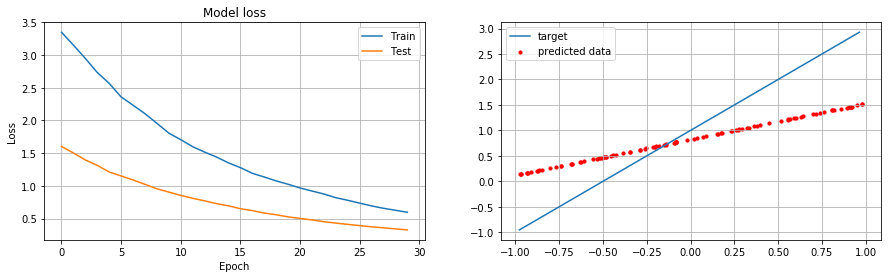

In [10]:
x_pred = np.random.uniform(-1, 1, 100)
loss_fit(lin1_hist,'Model loss',x_pred,lin1.predict(x_pred),lin_data[2][0],lin_data[2][1],'predicted')

Il grafico a destra mostra in maniera evidente il fallimento del training attuale della rete, come già anticipato dai valori ottenuti per i suoi parametri.

A sinistra vediamo che entrambi gli errori continuano a diminuire al crescere del numero di epoche. Questo è buono: per esempio un eventuale aumento da una certa epoca in poi di $E_{out}$ avrebbe potuto indicare un overfitting, condizione in cui la rete è troppo complessa per il numero di dati a disposizione ed inizia a fittarne anche il rumore. Qui chiaramente questa è un'eventualità del tutto impossibile, sia perchè i dati sono ora privi di rumore sia perché, più in generale, la macchina ha una struttura ovviamente troppo semplice. D'altra parte la diminuzione della funzione costo non è del tutto esaurita con l'epoca $N_{epochs}=30$, per cui una strada che si potrebbe seguire per migliorare il risultato è proprio quello di aumentare le epoche della fase di training.

Questo è il primo tentativo che ho fatto. Ho usato la stessa NN e l'ho trainata e validata con gli stessi dati, ma questa volta $N_{epochs}=100$.

In [11]:
lin2,lin2_hist = composeNN_singleN(lin_data,32,100,False)

Epoch 1/100
4/4 [==============================] - 0s 93ms/step - loss: 1.5474 - mse: 1.5474 - val_loss: 0.7946 - val_mse: 0.7946
Epoch 2/100
4/4 [==============================] - 0s 50ms/step - loss: 1.3953 - mse: 1.3953 - val_loss: 0.7049 - val_mse: 0.7049
Epoch 3/100
4/4 [==============================] - 0s 47ms/step - loss: 1.2593 - mse: 1.2593 - val_loss: 0.6430 - val_mse: 0.6430
Epoch 4/100
4/4 [==============================] - 0s 95ms/step - loss: 1.1626 - mse: 1.1626 - val_loss: 0.5672 - val_mse: 0.5672
Epoch 5/100
4/4 [==============================] - 0s 29ms/step - loss: 1.0428 - mse: 1.0428 - val_loss: 0.5059 - val_mse: 0.5059
Epoch 6/100
4/4 [==============================] - 0s 30ms/step - loss: 0.9449 - mse: 0.9449 - val_loss: 0.4592 - val_mse: 0.4592
Epoch 7/100
4/4 [==============================] - 0s 28ms/step - loss: 0.8680 - mse: 0.8680 - val_loss: 0.4258 - val_mse: 0.4258
Epoch 8/100
4/4 [==============================] - 0s 29ms/step - loss: 0.8100 - mse: 0.81

4/4 [==============================] - 0s 27ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 64/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 65/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 66/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 67/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 68/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 69/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 70/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0218 - mse: 0.0218 - 

In [12]:
print(lin2.get_weights())   # return weights

[array([[1.8862432]], dtype=float32), array([0.99271625], dtype=float32)]


In [13]:
evaluate(lin2,lin_data,32)

evaluate model with validation data:

1/1 [==============================] - 0s 8ms/step - loss: 0.0027 - mse: 0.0027

Test loss: 0.002710920525714755
Test accuracy: 0.002710920525714755

---------------------------------

evaluate model with the exact curve:

1/1 [==============================] - 0s 4ms/step - loss: 0.0027 - mse: 0.0027

Test loss: 0.002710920525714755
Test accuracy: 0.002710920525714755


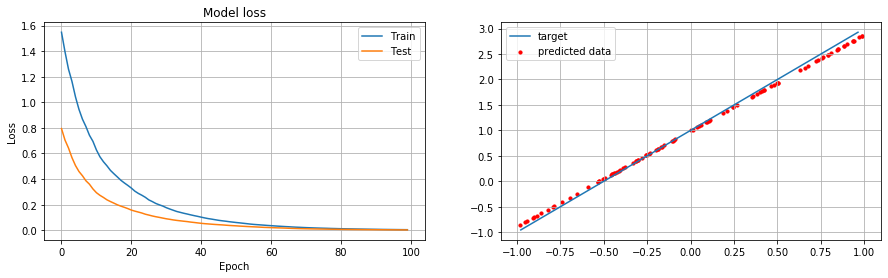

In [14]:
x_pred = np.random.uniform(-1, 1, 100)
loss_fit(lin2_hist,'Model loss',x_pred,lin2.predict(x_pred),lin_data[2][0],lin_data[2][1],'predicted')

La situazione è migliorata sensibilmente, ma ancora non è soddisfacente. Se non si avesse la possibilità di aumentare il numero di dati di training si potrebbe provare ad aumentare ancora il numero totale di epoche, ma il rate di diminuzione degli errori diminuisce sempre di più procedendo nel processo di ottimizzazione. La cosa migliore da fare è decisamente aumentare il numero di dati di training forniti alla rete.

I risultati che seguono sono ottenuti con $N_{epochs}=30$, $N_{train}=1000$ e $N_{valid}=100$. I dati sono generati ancora senza incertezza.

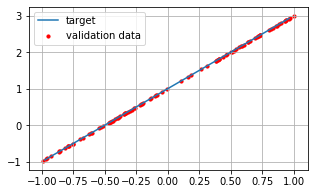

In [15]:
lin_newdata=data_gen(1000,100,linear,0)
plt.figure(figsize=(5,3))
reg_plot(lin_newdata[1][0],lin_newdata[1][1],xtg,ytg,'validation')

In [16]:
lin3,lin3_hist = composeNN_singleN(lin_newdata,32,30,False)

Epoch 1/30
32/32 [==============================] - 0s 13ms/step - loss: 1.3112 - mse: 1.3112 - val_loss: 0.8800 - val_mse: 0.8800
Epoch 2/30
32/32 [==============================] - 0s 7ms/step - loss: 0.6070 - mse: 0.6070 - val_loss: 0.4456 - val_mse: 0.4456
Epoch 3/30
32/32 [==============================] - 0s 6ms/step - loss: 0.3241 - mse: 0.3241 - val_loss: 0.2484 - val_mse: 0.2484
Epoch 4/30
32/32 [==============================] - 0s 6ms/step - loss: 0.1876 - mse: 0.1876 - val_loss: 0.1501 - val_mse: 0.1501
Epoch 5/30
32/32 [==============================] - ETA: 0s - loss: 0.1189 - mse: 0.118 - 0s 7ms/step - loss: 0.1154 - mse: 0.1154 - val_loss: 0.0932 - val_mse: 0.0932
Epoch 6/30
32/32 [==============================] - 0s 7ms/step - loss: 0.0724 - mse: 0.0724 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 7/30
32/32 [==============================] - 0s 7ms/step - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 8/30
32/32 [==============================] -

In [17]:
print(lin3.get_weights())   # return weights

[array([[1.9982377]], dtype=float32), array([1.0000494], dtype=float32)]


In [18]:
evaluate(lin3,lin_newdata,32)

evaluate model with validation data:

4/4 [==============================] - 0s 4ms/step - loss: 1.1276e-06 - mse: 1.1276e-06

Test loss: 1.1275670885879663e-06
Test accuracy: 1.1275670885879663e-06

---------------------------------

evaluate model with the exact curve:

4/4 [==============================] - 0s 4ms/step - loss: 1.1276e-06 - mse: 1.1276e-06

Test loss: 1.1275670885879663e-06
Test accuracy: 1.1275670885879663e-06


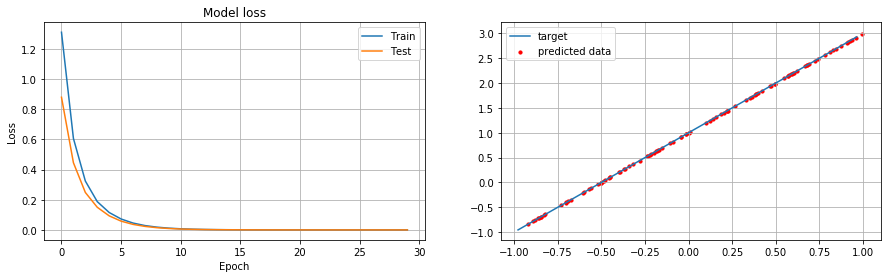

In [19]:
x_pred = np.random.uniform(-1, 1, 100)
loss_fit(lin3_hist,'Model loss',x_pred,lin3.predict(x_pred),lin_newdata[2][0],lin_newdata[2][1],'predicted')

La convergenza ora è molto buona. Non solo $30$ epoche sono state sufficienti, ma si potrebbero anche ridurre a circa la metà. Per un funzionamento ottimale della NN è molto più utile fornire molti dati piuttosto che aumentare la durata dell'ottimizzazione. D'altra parte uno dei concetti fondamentali alla base del Machine Learning è che una rete neurale per poter funzionare bene deve prima aver fatto esperienza su un numero di dati sufficiente.

Mantenendo lo stesso numero di dati e di epoche ho infine provato a fittare con la stessa rete dei dati generati con un rumore gaussiano con $\sigma=1$. 

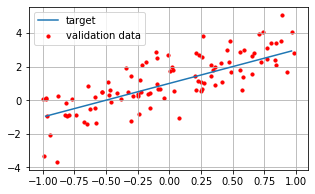

In [20]:
lin_dataerr=data_gen(1000,100,linear,1)
plt.figure(figsize=(5,3))
reg_plot(lin_dataerr[1][0],lin_dataerr[1][1],xtg,ytg,'validation')

In [21]:
lin4,lin4_hist = composeNN_singleN(lin_dataerr,32,30,False)

Epoch 1/30
32/32 [==============================] - 0s 12ms/step - loss: 3.3001 - mse: 3.3001 - val_loss: 3.1516 - val_mse: 3.1516
Epoch 2/30
32/32 [==============================] - 0s 8ms/step - loss: 2.3632 - mse: 2.3632 - val_loss: 2.3465 - val_mse: 2.3465
Epoch 3/30
32/32 [==============================] - 0s 7ms/step - loss: 1.8584 - mse: 1.8584 - val_loss: 1.8979 - val_mse: 1.8979
Epoch 4/30
32/32 [==============================] - 0s 7ms/step - loss: 1.5671 - mse: 1.5671 - val_loss: 1.6101 - val_mse: 1.6101
Epoch 5/30
32/32 [==============================] - 0s 7ms/step - loss: 1.3771 - mse: 1.3771 - val_loss: 1.4205 - val_mse: 1.4205
Epoch 6/30
32/32 [==============================] - 0s 7ms/step - loss: 1.2571 - mse: 1.2571 - val_loss: 1.2932 - val_mse: 1.2932
Epoch 7/30
32/32 [==============================] - 0s 7ms/step - loss: 1.1798 - mse: 1.1798 - val_loss: 1.2096 - val_mse: 1.2096
Epoch 8/30
32/32 [==============================] - 0s 6ms/step - loss: 1.1292 - mse: 1.1

In [22]:
print(lin4.get_weights())   # return weights

[array([[2.0137722]], dtype=float32), array([0.98553056], dtype=float32)]


In [23]:
evaluate(lin4,lin_dataerr,32)

evaluate model with validation data:

4/4 [==============================] - 0s 6ms/step - loss: 1.0004 - mse: 1.0004

Test loss: 1.000405192375183
Test accuracy: 1.000405192375183

---------------------------------

evaluate model with the exact curve:

4/4 [==============================] - 0s 4ms/step - loss: 2.7317e-04 - mse: 2.7317e-04

Test loss: 0.0002731708809733391
Test accuracy: 0.0002731708809733391


Gli errori qui sono più piccoli nel caso del confronto coi dati privi di errore. Questo è un ottimo segno, perché indica che la rete ha completato la regressione riuscendo anche in qualche modo a ripulire i dati di train dal rumore e a riconoscere quindi la vera funzione target, come si vede anche nel grafico finale.

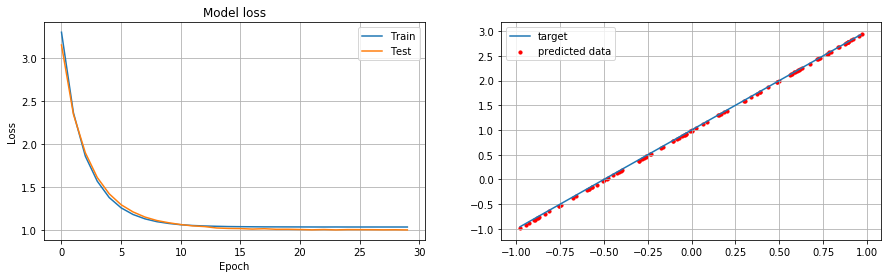

In [24]:
x_pred = np.random.uniform(-1, 1, 100)
loss_fit(lin4_hist,'Model loss',x_pred,lin4.predict(x_pred),lin_dataerr[2][0],lin_dataerr[2][1],'predicted')

Anche qui il grafico delle loss suggerisce che il numero di epoche potrebbe essere in parte ridotto. Il più alto valore delle funzioni costo è dovuto all'introduzione nei dati dell'errore statistico.

### Esercizio 11.2

Passo quindi a fittare dati generati secondo la funzione polinomiale

$$ f(x)=4-3x-2x^2+3x^3 $$

nell'intervallo $[-1,1]$. I dati sono soggetti ad un errore gaussiano con $\sigma=0.3$. Per una migliore efficienza delle NNs il numero di punti di training è stato aumentato a $N_{train}=10^4$.

In questo esercizio provo ad utilizzare differenti strutture, funzioni di attivazione, funzioni costo e ottimizzatori per costruire le reti neurali e a vedere come cambiano i risultati del fit in funzione di questo. Con le NN ottimizzate proverò a predirre gli output corrispondenti a nuovi dati generati sia all'interno che all'esterno dell'intervallo di training.

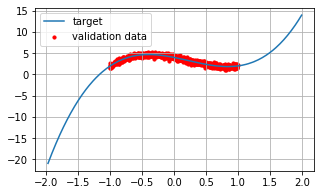

In [25]:
poly_data=data_gen(int(1e4),1000,polynomial,0.3)
xtg=np.random.uniform(-2, 2, 500)  #x_target only for the graph
xtg.sort()
ytg=polynomial(xtg)

plt.figure(figsize=(5,3))
reg_plot(poly_data[1][0],poly_data[1][1],xtg,ytg,'validation')

Anche prima di effettuare test è chiaro che la funzione risposta dei neuroni della rete non può più essere lasciata lineare, perché una NN così costruita non potrebbe che produrre output lineari. Farò comunque una prova con un numero relativamente alto di layer e di neuroni per layer per mostrare questa cosa.\
Contemporaneamente testerò tre reti con un numero simile di parametri in cui provo rispettivamente ad aumentare il numero di neuroni di un unico layer interno, ad aumentare il numero di layer a singolo neurone e infine a fare una combinazione di entrambe le operazioni.

In [26]:
def compileNN(models,optimizer,loss,met):   #compile the model choosing optimizer, loss and metrics objects
    for mod in models:
        mod.compile(optimizer=optimizer, loss=loss, metrics=[met])
        mod.summary(); print()    

def history(models,data,bsize,epochs):    # fit the model using training dataset
    if type(epochs) is int: ep=[epochs for i in range(len(models))]
    else: ep=epochs
    return [models[i].fit(x=data[0][0],y=data[0][1], 
          batch_size=bsize, epochs=ep[i], shuffle=True,
          validation_data=(data[1][0],data[1][1]))
          for i in range(len(models))]

In [27]:
#linear activation function
lin = tf.keras.Sequential()
lin.add(Dense(20,input_shape=(1,)))
for i in range(4): lin.add(Dense(15))
lin.add(Dense(1))

#more neurons
moreN = tf.keras.Sequential()
moreN.add(Dense(12,input_shape=(1,),activation='selu'))
moreN.add(Dense(1,activation='selu'))

#more layers
moreL = tf.keras.Sequential()
moreL.add(Dense(1,input_shape=(1,),activation='selu'))
for i in range(17): moreL.add(Dense(1,activation='selu'))

#more neurons and layers
poly1 = tf.keras.Sequential()
#for i in range(4): poly1.add(Dense(3,input_shape=(1,),activation='selu'))
#for i in range(4): poly1.add(Dense(4-i,input_shape=(1,),activation='selu'))
for i in range(4): poly1.add(Dense(1+i,input_shape=(1,),activation='selu'))
poly1.add(Dense(1,activation='selu'))

models1=[lin,moreN,moreL,poly1]
compileNN(models1,SGD(),'mse','mse')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_5 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_6 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_7 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_8 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 16        
Total params: 1,091
Trainable params: 1,091
Non-trainable params: 0
____________________________________________________

In [28]:
hist1 = history(models1,poly_data,150,15)

Epoch 1/15
67/67 [==============================] - 1s 10ms/step - loss: 1.1765 - mse: 1.1765 - val_loss: 0.6310 - val_mse: 0.6310
Epoch 2/15
67/67 [==============================] - 0s 6ms/step - loss: 0.6767 - mse: 0.6767 - val_loss: 0.6331 - val_mse: 0.6331
Epoch 3/15
67/67 [==============================] - 0s 6ms/step - loss: 0.6748 - mse: 0.6748 - val_loss: 0.6438 - val_mse: 0.6438
Epoch 4/15
67/67 [==============================] - 0s 6ms/step - loss: 0.6739 - mse: 0.6739 - val_loss: 0.6587 - val_mse: 0.6587
Epoch 5/15
67/67 [==============================] - 0s 6ms/step - loss: 0.6760 - mse: 0.6760 - val_loss: 0.6707 - val_mse: 0.6707
Epoch 6/15
67/67 [==============================] - 0s 6ms/step - loss: 0.6730 - mse: 0.6730 - val_loss: 0.6397 - val_mse: 0.6397
Epoch 7/15
67/67 [==============================] - 0s 6ms/step - loss: 0.6715 - mse: 0.6715 - val_loss: 0.6557 - val_mse: 0.6557
Epoch 8/15
67/67 [==============================] - 0s 6ms/step - loss: 0.6733 - mse: 0.6

In [29]:
def evals(models,data,bsize,j):   #j=0 for validation data, j=1 for target
    rg=range(len(models))
    scores=list(0 for i in rg)
    tit=('validation data','the exact curve')

    print('evaluate model with '+tit[j]+':'); print()
    for i in rg: scores[i]=models[i].evaluate(data[j+1][0],data[j+1][1], batch_size=bsize, verbose=1)
    loss=tuple(scores[i][0] for i in rg); val=tuple(scores[i][1] for i in rg)
    # print performance
    print(); print('Test loss:'); print(loss)
    print('Test accuracy:'); print(val)

In [30]:
evals(models1,poly_data,150,0)

evaluate model with validation data:

7/7 [==============================] - 0s 5ms/step - loss: 0.0981 - mse: 0.0981

Test loss:
(0.6304781436920166, 0.22801350057125092, 1.1111552715301514, 0.09810148179531097)
Test accuracy:
(0.6304781436920166, 0.22801350057125092, 1.1111552715301514, 0.09810148179531097)


In [31]:
def plot_hist(histories,title):
    many=len(histories)
    for i in range(many):
        plt.subplot(int((many+1)/2),2,i+1)
        losses(histories[i],title[i])
    plt.suptitle('Models losses')
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
    
def fit(models,data):
    plt.figure(figsize=(15,6))
    for lim in range(2):
        plt.subplot(1,2,lim+1)
        x_pred = np.random.uniform(-lim-1, lim+1, 200)
        plt.plot(xtg,ytg)
        for i in range(len(models)):
            y_pred=models[i].predict(x_pred)
            plt.scatter(x_pred,y_pred,marker='.',label=title[i])
        plt.axvline(x=-1,color='k',linewidth=0.8)
        plt.axvline(x=1,color='k',linewidth=0.8)
        if(lim==0):
            plt.xlim(-1.1,1.1)
            plt.ylim(1,5)
        plt.legend(loc='best')
        plt.grid(True)
        if(lim==0): plt.title('inside training range')
        else: plt.title('outside training range')
    plt.suptitle('NNs predictions')
    plt.show()

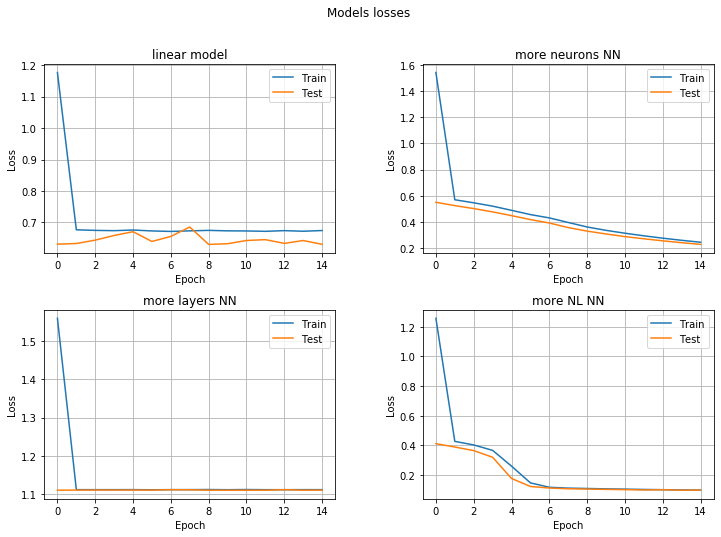

In [32]:
title=('linear model','more neurons NN','more layers NN','more NL NN')
plt.figure(figsize=(12,8))
plot_hist(hist1,title)

Già da questi grafici è evidente che la NN lineare non sarà mai in grado di fittare la funzione polinomiale di interesse. L'opzione di aumentare simultaneamente numero di layer e di neuroni per layer sembra essere quella che porta alla rete neurale più efficiente. Eseguendo vari test ho inoltre notato che in quest'ultimo caso sembra più efficace far crescere il numero di neuroni (piuttosto che tenerli costanti o farli diminuire) nei layer nascosti muovendosi da quello di input verso quello di output.

In [33]:
evals(models1,poly_data,150,1)

evaluate model with the exact curve:

7/7 [==============================] - 0s 3ms/step - loss: 0.0113 - mse: 0.0113

Test loss:
(0.5460366010665894, 0.1386825144290924, 1.0397462844848633, 0.011251297779381275)
Test accuracy:
(0.5460366010665894, 0.1386825144290924, 1.0397462844848633, 0.011251297779381275)


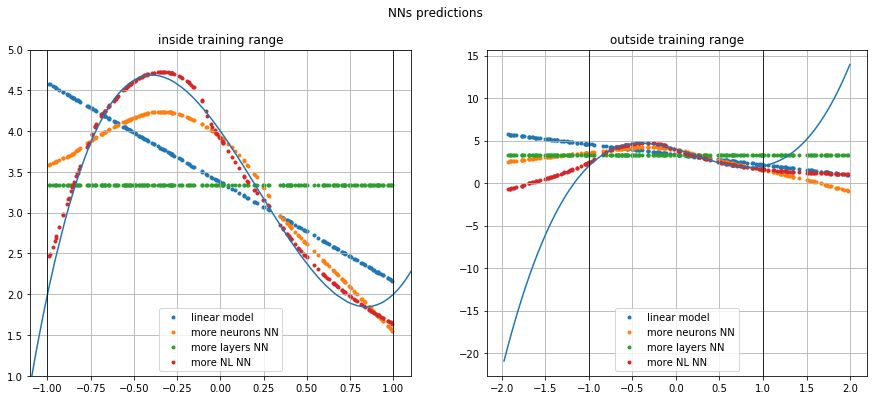

In [34]:
fit(models1,poly_data)

Come era da aspettarsi la NN lineare è del tutto da scartare. Era prevedibile anche il fallimento del test di solo aumento dei layers. In questo secondo caso si cerca infatti in pratica di fittare un polinomio di terzo grado utilizzando in ogni layer solo funzioni risposta monotone. Confrontando errori finali e grafico del fit la scelta migliore sembra essere quella di aumentare contemporaneamente numero di layer e numero di neuroni.

All'esterno del range di training la situazione è del tutto critica in tutti i casi considerati. In effetti si sta chiedendo alla rete di predire il comportamento della funzione target in regioni dello spazio rispetto alle quali non ha ricevuto nessun tipo di informazione in fase di training. E' chiaro che l'esito non può essere in alcun modo affidabile.

Basandomi su queste osservazioni sono passato a testare delle reti a $5$ layer nascosti e a neuroni multipli ed in numero crescente verso il layer di output, tutte distinte per le diverse funzioni di attivazione.\
Poichè nel range studiato la funzione assume solo valori positivi si possono anche usare senza problemi funzioni di attivazione aventi come codominio solo il semiasse reale positivo, come la relu. Per l'ultima delle reti utilizzate provo anche ad usare la funzione sigmoide. Questa però è limitata sia inferiormente che superiormente a produrre valori in modulo minori di $1$, e quindi non può essere usata anche per il layer di output se l'obiettivo è quello di rappresentare correttamente la funzione polinomiale oggetto del fit. Per l'ultimo layer di questa NN ho quindi provato a usare ancora una selu.

In [35]:
def composeNN(activation,big):    #big=1 for a bigger NN, big=2 for 3D case
    rg=(range(4),range(5),range(8)); dim=(1,1,2)
    def par(i): return (3+2*i,5*(i+1),5*(i+1))
    
    #compose the NN model
    model = tf.keras.Sequential()
    model.add(Dense(2,input_shape=(dim[big],),activation=activation))
    for i in rg[big]: model.add(Dense(par(i)[big],activation=activation))
    if(big==2): model.add(Dropout(0.5))
    model.add(Dense(1,activation=activation))
    return model

In [36]:
models_act=(composeNN('selu',0),composeNN('elu',0),composeNN('relu',0),composeNN('sigmoid',0))
compileNN(models_act,SGD(),'mse','mse')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_38 (Dense)             (None, 7)                 42        
_________________________________________________________________
dense_39 (Dense)             (None, 9)                 72        
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 10        
Total params: 157
Trainable params: 157
Non-trainable params: 0
________________________________________________________

In [37]:
hist_act = history(models_act,poly_data,150,15)

Epoch 1/15
67/67 [==============================] - 1s 17ms/step - loss: 0.9335 - mse: 0.9335 - val_loss: 0.4304 - val_mse: 0.4304
Epoch 2/15
67/67 [==============================] - 1s 10ms/step - loss: 0.3914 - mse: 0.3914 - val_loss: 0.3264 - val_mse: 0.3264
Epoch 3/15
67/67 [==============================] - 0s 7ms/step - loss: 0.2670 - mse: 0.2670 - val_loss: 0.2647 - val_mse: 0.2647
Epoch 4/15
67/67 [==============================] - 1s 10ms/step - loss: 0.2691 - mse: 0.2691 - val_loss: 0.1825 - val_mse: 0.1825
Epoch 5/15
67/67 [==============================] - 1s 15ms/step - loss: 0.2130 - mse: 0.2130 - val_loss: 0.1735 - val_mse: 0.1735
Epoch 6/15
67/67 [==============================] - 1s 9ms/step - loss: 0.1997 - mse: 0.1997 - val_loss: 0.1624 - val_mse: 0.1624
Epoch 7/15
67/67 [==============================] - 1s 12ms/step - loss: 0.1537 - mse: 0.1537 - val_loss: 0.1538 - val_mse: 0.1538
Epoch 8/15
67/67 [==============================] - 1s 8ms/step - loss: 0.1748 - mse:

In [38]:
evals(models_act,poly_data,150,0)

evaluate model with validation data:

7/7 [==============================] - 0s 4ms/step - loss: 6.7148 - mse: 6.7148

Test loss:
(0.13495106995105743, 0.10528702288866043, 0.31860992312431335, 6.714778900146484)
Test accuracy:
(0.13495108485221863, 0.10528702288866043, 0.31860992312431335, 6.714778900146484)


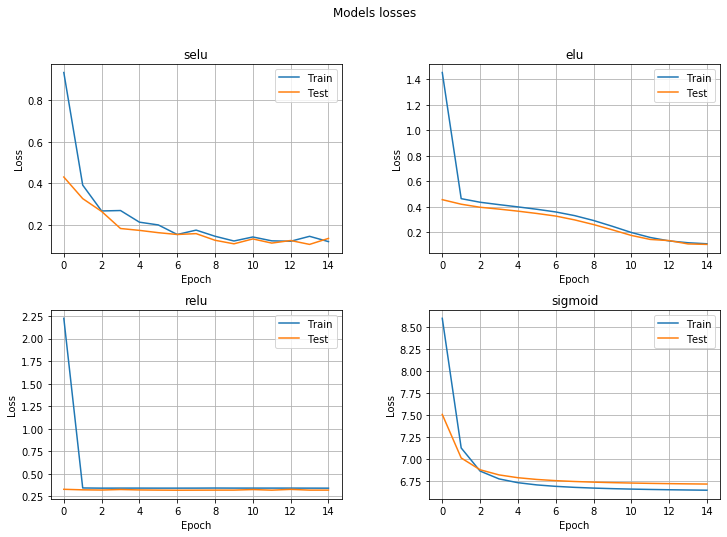

In [39]:
title=('selu','elu','relu','sigmoid')
plt.figure(figsize=(12,8))
plot_hist(hist_act,title)

Evidentemente l'utilizzo delle sigmoidi è da escludere.

In [40]:
evals(models_act,poly_data,150,1)

evaluate model with the exact curve:

7/7 [==============================] - 0s 4ms/step - loss: 6.6649 - mse: 6.6649

Test loss:
(0.051956359297037125, 0.018917981535196304, 0.22769330441951752, 6.664851665496826)
Test accuracy:
(0.051956359297037125, 0.018917979672551155, 0.22769330441951752, 6.664851665496826)


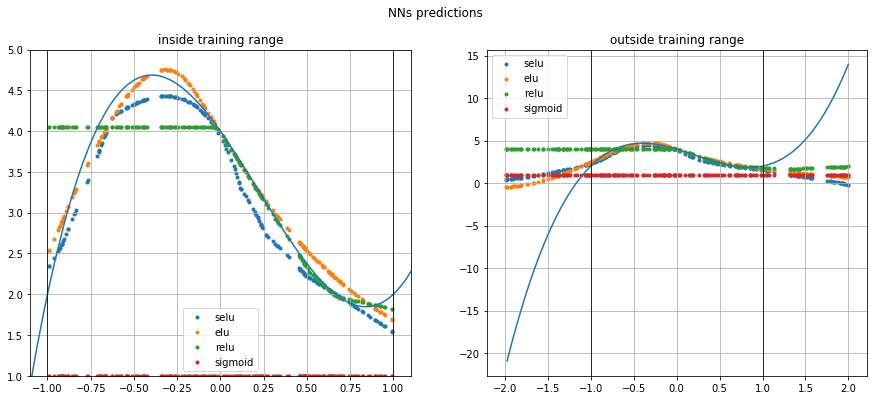

In [41]:
fit(models_act,poly_data)

La funzione selu sembra quella su cui puntare per questo problema (anche se non è escluso che in realtà le altre risultino più adatte cambiando l'ottimizzatore o la loss function; non eseguirò questo test). Nel seguito continuerò ad utilizzare questa funzione di attivazione.

Chiaramente le predizioni all'esterno del range di training sono ancora del tutto sbagliate.

Provo ora a variare metodo di ottimizzazione (in particolare testo l'utilizzo di *Adadelta* e *Adam*, più sofisticati del semplice *stochastic gradient descent* usato finora) e loss function (proverò la MAE, *mean absolute error* e la MSLE, *mean squared logarithmic error*), mantenendo come funzione di attivazione sempre la selu e utilizzando delle reti composte da 5 layer interni a neuroni crescenti, uno di dropout per evitare l'overfitting (soprattutto per *Adam*) e uno di output (obbligatoriamente) a singolo neurone.

In [42]:
models_poly=list(composeNN('selu',1) for i in range(6))
models_poly[0].compile(optimizer=SGD(),loss='mse',metrics=['mse'])
models_poly[1].compile(optimizer=Adadelta(),loss='mse',metrics=['mse'])
models_poly[2].compile(optimizer=Adadelta(),loss='mae',metrics=['mae'])
models_poly[3].compile(optimizer=Adam(),loss='mse',metrics=['mse'])
models_poly[4].compile(optimizer=Adam(),loss='mae',metrics=['mae'])
models_poly[5].compile(optimizer=Adam(),loss='msle',metrics=['msle'])
for mod in models_poly: mod.summary(); print()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_60 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_61 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_62 (Dense)             (None, 15)                165       
_________________________________________________________________
dense_63 (Dense)             (None, 20)                320       
_________________________________________________________________
dense_64 (Dense)             (None, 25)                525       
_________________________________________________________________
dense_65 (Dense)             (None, 1)               

Dopo una prima prova ho visto che per entrambe le reti ottimizzate con *Adadelta* serve un numero di epoche maggiore, almeno $N_{epochs}=100$, per arrivare a valori accettabili della loss.

In [43]:
hist_poly = history(models_poly,poly_data,150,(15,100,100,15,15,15))

Epoch 1/15
67/67 [==============================] - 2s 27ms/step - loss: 0.6661 - mse: 0.6661 - val_loss: 0.3137 - val_mse: 0.3137
Epoch 2/15
67/67 [==============================] - 1s 14ms/step - loss: 0.1651 - mse: 0.1651 - val_loss: 0.1229 - val_mse: 0.1229
Epoch 3/15
67/67 [==============================] - 1s 8ms/step - loss: 0.1348 - mse: 0.1348 - val_loss: 0.1089 - val_mse: 0.1089
Epoch 4/15
67/67 [==============================] - 0s 7ms/step - loss: 0.1154 - mse: 0.1154 - val_loss: 0.1037 - val_mse: 0.1037
Epoch 5/15
67/67 [==============================] - 0s 5ms/step - loss: 0.1111 - mse: 0.1111 - val_loss: 0.1121 - val_mse: 0.1121
Epoch 6/15
67/67 [==============================] - 0s 5ms/step - loss: 0.1022 - mse: 0.1022 - val_loss: 0.1106 - val_mse: 0.1106
Epoch 7/15
67/67 [==============================] - 0s 5ms/step - loss: 0.1251 - mse: 0.1251 - val_loss: 0.1185 - val_mse: 0.1185
Epoch 8/15
67/67 [==============================] - 0s 6ms/step - loss: 0.1028 - mse: 0.

67/67 [==============================] - 0s 2ms/step - loss: 5.3991 - mse: 5.3991 - val_loss: 5.4541 - val_mse: 5.4541
Epoch 49/100
67/67 [==============================] - 0s 7ms/step - loss: 5.2812 - mse: 5.2812 - val_loss: 5.3344 - val_mse: 5.3344
Epoch 50/100
67/67 [==============================] - 1s 11ms/step - loss: 5.1630 - mse: 5.1630 - val_loss: 5.2142 - val_mse: 5.2142
Epoch 51/100
67/67 [==============================] - 1s 12ms/step - loss: 5.0445 - mse: 5.0445 - val_loss: 5.0939 - val_mse: 5.0939
Epoch 52/100
67/67 [==============================] - 1s 12ms/step - loss: 4.9258 - mse: 4.9258 - val_loss: 4.9735 - val_mse: 4.9735
Epoch 53/100
67/67 [==============================] - 1s 18ms/step - loss: 4.8071 - mse: 4.8071 - val_loss: 4.8529 - val_mse: 4.8529
Epoch 54/100
67/67 [==============================] - 1s 12ms/step - loss: 4.6884 - mse: 4.6884 - val_loss: 4.7324 - val_mse: 4.7324
Epoch 55/100
67/67 [==============================] - 1s 13ms/step - loss: 4.5698 - 

67/67 [==============================] - 1s 10ms/step - loss: 3.2359 - mae: 3.2359 - val_loss: 3.2254 - val_mae: 3.2254
Epoch 11/100
67/67 [==============================] - 1s 11ms/step - loss: 3.2251 - mae: 3.2251 - val_loss: 3.2144 - val_mae: 3.2144
Epoch 12/100
67/67 [==============================] - 1s 11ms/step - loss: 3.2141 - mae: 3.2141 - val_loss: 3.2032 - val_mae: 3.2032
Epoch 13/100
67/67 [==============================] - 1s 11ms/step - loss: 3.2031 - mae: 3.2031 - val_loss: 3.1921 - val_mae: 3.1921
Epoch 14/100
67/67 [==============================] - 1s 11ms/step - loss: 3.1920 - mae: 3.1920 - val_loss: 3.1808 - val_mae: 3.1808
Epoch 15/100
67/67 [==============================] - 1s 10ms/step - loss: 3.1808 - mae: 3.1808 - val_loss: 3.1695 - val_mae: 3.1695
Epoch 16/100
67/67 [==============================] - 1s 8ms/step - loss: 3.1695 - mae: 3.1695 - val_loss: 3.1582 - val_mae: 3.1582
Epoch 17/100
67/67 [==============================] - 0s 7ms/step - loss: 3.1583 - 

Epoch 72/100
67/67 [==============================] - 0s 5ms/step - loss: 1.9593 - mae: 1.9593 - val_loss: 1.9505 - val_mae: 1.9505
Epoch 73/100
67/67 [==============================] - 0s 5ms/step - loss: 1.9220 - mae: 1.9220 - val_loss: 1.9127 - val_mae: 1.9127
Epoch 74/100
67/67 [==============================] - 0s 4ms/step - loss: 1.8831 - mae: 1.8831 - val_loss: 1.8733 - val_mae: 1.8733
Epoch 75/100
67/67 [==============================] - 0s 5ms/step - loss: 1.8425 - mae: 1.8425 - val_loss: 1.8322 - val_mae: 1.8322
Epoch 76/100
67/67 [==============================] - 1s 8ms/step - loss: 1.8000 - mae: 1.8000 - val_loss: 1.7888 - val_mae: 1.7888
Epoch 77/100
67/67 [==============================] - 1s 8ms/step - loss: 1.7547 - mae: 1.7547 - val_loss: 1.7427 - val_mae: 1.7427
Epoch 78/100
67/67 [==============================] - 1s 11ms/step - loss: 1.7073 - mae: 1.7073 - val_loss: 1.6947 - val_mae: 1.6947
Epoch 79/100
67/67 [==============================] - 1s 14ms/step - loss: 

67/67 [==============================] - 1s 8ms/step - loss: 0.0194 - msle: 0.0194 - val_loss: 0.0173 - val_msle: 0.0173
Epoch 5/15
67/67 [==============================] - 0s 7ms/step - loss: 0.0164 - msle: 0.0164 - val_loss: 0.0147 - val_msle: 0.0147
Epoch 6/15
67/67 [==============================] - 1s 8ms/step - loss: 0.0137 - msle: 0.0137 - val_loss: 0.0124 - val_msle: 0.0124
Epoch 7/15
67/67 [==============================] - 1s 8ms/step - loss: 0.0113 - msle: 0.0113 - val_loss: 0.0103 - val_msle: 0.0103
Epoch 8/15
67/67 [==============================] - 1s 8ms/step - loss: 0.0094 - msle: 0.0094 - val_loss: 0.0090 - val_msle: 0.0090
Epoch 9/15
67/67 [==============================] - 1s 9ms/step - loss: 0.0082 - msle: 0.0082 - val_loss: 0.0080 - val_msle: 0.0080
Epoch 10/15
67/67 [==============================] - 1s 8ms/step - loss: 0.0075 - msle: 0.0075 - val_loss: 0.0077 - val_msle: 0.0077
Epoch 11/15
67/67 [==============================] - 1s 8ms/step - loss: 0.0071 - msle

In [44]:
evals(models_poly,poly_data,150,0)

evaluate model with validation data:

7/7 [==============================] - 0s 5ms/step - loss: 0.0064 - msle: 0.0064

Test loss:
(0.09863986074924469, 0.7264267802238464, 0.6103678941726685, 0.09186914563179016, 0.23601621389389038, 0.006420648656785488)
Test accuracy:
(0.09863986074924469, 0.7264267802238464, 0.6103678941726685, 0.09186914563179016, 0.23601621389389038, 0.006420648656785488)


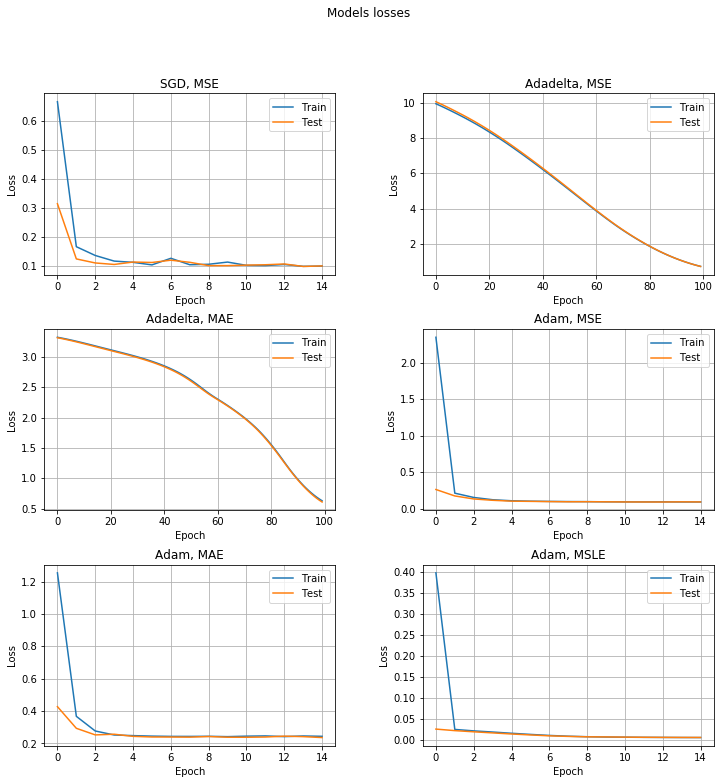

In [45]:
title=('SGD, MSE','Adadelta, MSE','Adadelta, MAE','Adam, MSE','Adam, MAE','Adam, MSLE')
plt.figure(figsize=(12,12))
plot_hist(hist_poly,title)

In [46]:
evals(models_poly,poly_data,150,1)

evaluate model with the exact curve:

7/7 [==============================] - 0s 4ms/step - loss: 4.4716e-04 - msle: 4.4716e-04

Test loss:
(0.010954085737466812, 0.6492345333099365, 0.5693793296813965, 0.0037889962550252676, 0.03300312161445618, 0.0004471615538932383)
Test accuracy:
(0.010954085737466812, 0.6492345333099365, 0.5693793296813965, 0.0037889962550252676, 0.03300312161445618, 0.0004471615538932383)


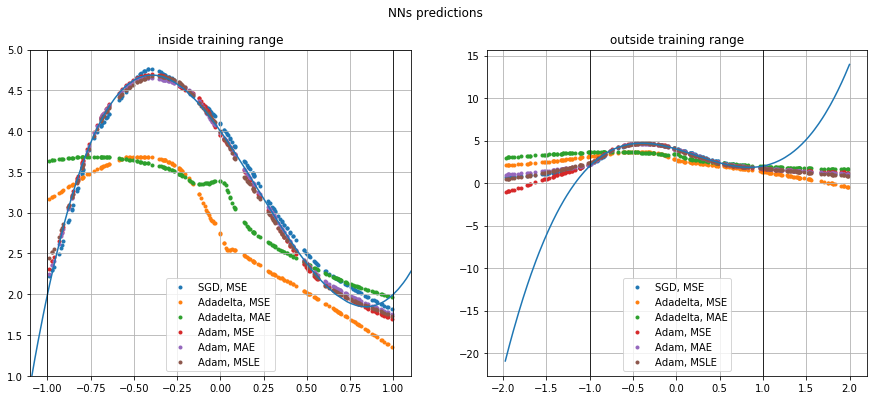

In [47]:
fit(models_poly,poly_data)

Per capire quale sia l'opzione migliore adesso bisogna fare attenzione, perché le loss valutate sono differenti. Sicuramente le due reti che utilizzano *Adadelta* possono essere scartate. Certamente facendo proseguire il train per un numero maggiore di epoche le prestazioni di queste NN potrebbero migliorare, ma allora è meglio concentrarsi sulle altre opzioni, più efficienti. La prima rete è scartata sia dal fit grafico che dal confronto della loss con la prima delle reti *Adam*. Queste tre giungono a dei fit di qualità simile. Nell'ultimo esercizio sarà questo l'ottimizzatore utilizzato.

In conclusione per una NN è fondamentale innanzitutto avere un set piuttosto grande di dati di training: più questi sono numerosi più l'apprendimento della macchina è efficiente e le sue previsioni sono accurate. Questo vale però solamente per predizioni all'interno del range di valori in cui la rete è stata trainata. All'esterno di esso la rete non ha alcuna informazione sull'andamento della funzione che sta fittando, e quindi le previsioni risultano qui del tutto inaffidabili.

E' inoltre importante anche valutare l'andamento delle loss in funzione del numero di epoche, per capire sia se l'apprendimento ha raggiunto una qualche convergenza (e quindi il numero di epoche scelte può essere valutato sufficiente) sia per essere sicuri di non fare overfitting.

Tipicamente piuttosto che aumentare la complessità della rete (cosa che porta ad un aumento anche significativo del peso computazionale) è preferibile aumentare il numero di dati forniti ad essa in fase di training ("bias-variance tradeoff"). Nel caso in cui questo non sia possibile allora un aumento del numero di neuroni per layer può essere necessario, e un corrispondente aumento di layer può portare ad un efficienza significativamente migliore a parità di complessità della rete. Bisogna però in questo caso sempre stare attenti non solo all'aumento del costo computazionale delle operazioni di training, ma anche e soprattutto al pericolo di overfitting, situazione in cui la rete è troppo complessa in relazione al numero di dati forniti e comincia quindi a fittarne il rumore sperimentale.

In generale è necessario avere funzioni di attivazione non lineari. In caso contrario la rete può solo generare mappe che sono, appunto, lineari. Sembra inoltre preferibile scegliere funzioni non limitate, almeno nei casi di funzioni target non limitate come quelle trattate. I limiti della funzione attivazione sembrano in caso contrario essere un ostacolo nel processo di ottimizzazione.\
Particolare attenzione va prestata alla funzione di attivazione dell'ultimo layer, che deve se possibile essere scelta in funzione delle conoscenze a priori sugli output. Se per esempio la funzione target può produrre anche valori negativi una funzione di attivazione definita positiva, come la relu, non può essere scelta per il layer di output, che non sarebbe altrimenti in grado di produrre in alcun modo valori negativi in uscita.

Come ottimizzatore *Adam* sembra molto buono, ma deve spesso essere accoppiato a dei layer di dropout per evitare overfitting.\
Non ho notato particolari differenze tra diverse scelte delle funzioni costo.

### Esercizio 11.3

Nell'ultimo esercizio i dati da fittare sono generati dalla funzione bidimensionale $f(x,y) = \sin(x^2+y^2)$ nel range $x \in [-3/2,3/2]$ e $y \in [-3/2,3/2]$. La rete neurale è simile alle ultime utilizzate nel problema precedente, ma più complessa. L'ottimizzatore utilizzato è *Adam*, la funzione di attivazione è la selu e la funzione costo la MSE. I dati hanno un rumore gaussiano con $\sigma=0.3$ e ho usato $N_{train}=10^5$ e $N_{valid}=10^4$.

In [48]:
def target3D(x,y): return np.sin(x**2 + y**2)

def plot3D(xyz,target,lab):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_trisurf(target[0],target[1],target[2],linewidth=0,antialiased=False,alpha=0.3)
    ax.scatter(xyz[0],xyz[1],xyz[2],c=xyz[2],marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(30, 30)
    plt.title('Target and '+lab, y=1.05)
    plt.show()

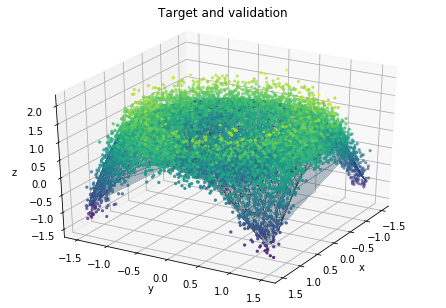

In [49]:
sigma=0.3
#generate training data
x_train = np.random.uniform(-1.5, 1.5, int(1e5))
y_train = np.random.uniform(-1.5, 1.5, int(1e5))
train = np.stack([x_train,y_train],axis=1)  #actual measures from which we want to guess regression parameters
z_train = np.random.normal(target3D(x_train,y_train),sigma)
#generate validation data
x_valid = np.random.uniform(-1.5, 1.5, int(1e4))
y_valid = np.random.uniform(-1.5, 1.5, int(1e4))
valid = np.stack([x_valid,y_valid],axis=1)
z_valid = np.random.normal(target3D(x_valid,y_valid),sigma)
# ideal (target) function for error evaluation
x_target=x_valid; y_target=y_valid
target = np.stack([x_target,y_target],axis=1)
z_target = target3D(x_target,y_target)
#x_target only for the graph
xtg=[np.random.uniform(-1.5, 1.5, 5000) for i in ('x','y')]
targ=np.stack([xtg[0],xtg[1],target3D(xtg[0],xtg[1])],axis=0)

plot3D((x_valid,y_valid,z_valid),targ,'validation')

In [50]:
mod3D=composeNN('selu',2)
mod3D.compile(optimizer=Adam(),loss='mse',metrics=['mse'])
mod3D.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_102 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_103 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_104 (Dense)            (None, 15)                165       
_________________________________________________________________
dense_105 (Dense)            (None, 20)                320       
_________________________________________________________________
dense_106 (Dense)            (None, 25)                525       
_________________________________________________________________
dense_107 (Dense)            (None, 30)              

In [51]:
hist3D = mod3D.fit(x=train,y=z_train,batch_size=500,epochs=15,shuffle=True,validation_data=(valid,z_valid))

Epoch 1/15
200/200 [==============================] - 3s 15ms/step - loss: 0.3332 - mse: 0.3332 - val_loss: 0.1819 - val_mse: 0.1819
Epoch 2/15
200/200 [==============================] - 3s 16ms/step - loss: 0.1824 - mse: 0.1824 - val_loss: 0.1544 - val_mse: 0.1544
Epoch 3/15
200/200 [==============================] - 3s 13ms/step - loss: 0.1610 - mse: 0.1610 - val_loss: 0.1382 - val_mse: 0.1382
Epoch 4/15
200/200 [==============================] - 3s 13ms/step - loss: 0.1409 - mse: 0.1409 - val_loss: 0.1179 - val_mse: 0.1179loss: 0.1449 - mse: - ETA: 0s - loss: 0.1429 - m
Epoch 5/15
200/200 [==============================] - 3s 13ms/step - loss: 0.1307 - mse: 0.1307 - val_loss: 0.1134 - val_mse: 0.1134
Epoch 6/15
200/200 [==============================] - 3s 13ms/step - loss: 0.1236 - mse: 0.1236 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 7/15
200/200 [==============================] - 3s 16ms/step - loss: 0.1186 - mse: 0.1186 - val_loss: 0.1193 - val_mse: 0.1193
Epoch 8/15
200/200 [=

In [52]:
# evaluate model
score = mod3D.evaluate(valid,z_valid, batch_size=500, verbose=1)
# print performance, validation set
print()
print('Test loss:    ',score[0])
print('Test accuracy:',score[1])

20/20 [==============================] - 0s 9ms/step - loss: 0.0972 - mse: 0.0972

Test loss:     0.09719715267419815
Test accuracy: 0.09719715267419815


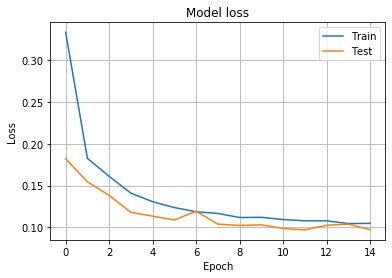

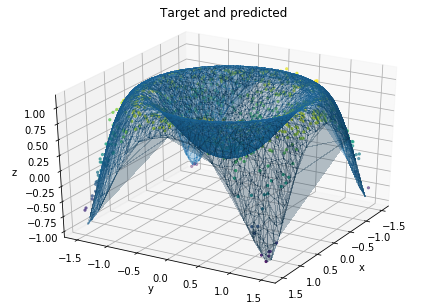

In [53]:
losses(hist3D,'Model loss')

x_pred=np.random.uniform(-1.5, 1.5, int(1e3))
y_pred=np.random.uniform(-1.5, 1.5, int(1e3))
pred=np.stack([x_pred,y_pred],axis=1)
z_pred=mod3D.predict(pred)
plot3D((x_pred,y_pred,z_pred[:,0]),targ,'predicted')

La regressione è riuscita.